In [2546]:
!unzip Train_Dataset.zip

unzip:  cannot find or open Train_Dataset.zip, Train_Dataset.zip.zip or Train_Dataset.zip.ZIP.


In [2547]:
!rm Train_Dataset.zip

rm: Train_Dataset.zip: No such file or directory


In [2548]:
#importing neccesary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer

In [2549]:
dataset = pd.read_csv('train.csv',low_memory=False)
dataset.dtypes

ID                           object
Customer_ID                  object
Month                        object
Name                         object
Age                          object
SSN                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
Credit_Score                

In [2550]:

#dropping features which are not useful for determining the credit score
final_dataset = dataset.drop(["Amount_invested_monthly", "SSN", "Name", "Month", "Age", "Num_Bank_Accounts", "Num_Credit_Card", "Interest_Rate", "Type_of_Loan", "Changed_Credit_Limit", "Num_Credit_Inquiries", "Credit_Mix", "Credit_Utilization_Ratio"], axis=1)

In [2551]:
dataset.to_csv('final_dataset.csv', index=False)

In [2552]:
final_dataset = pd.read_csv('final_dataset.csv', low_memory=False)
x = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

In [2553]:
final_dataset.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [2554]:
final_dataset.shape

(100000, 28)

Cleaning errors and fixing variables

In [2555]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

Deal with the missing values of Monthly_Inhand_Salary columns

In [2556]:
# Convert the Customer_ID column to a factor
final_dataset['Customer_ID'] = final_dataset['Customer_ID'].astype('category')

# Calculate the median Inhand Salary by customer using groupby and summarize
median_Inhand_salary_by_customer = final_dataset.groupby('Customer_ID').agg(median_salary=('Monthly_Inhand_Salary', 'median'))

# Join the median salary column to the dataset
final_dataset = pd.merge(final_dataset, median_Inhand_salary_by_customer, on='Customer_ID', how='left')

# Replace missing values in Monthly Inhand Salary column with median salary
final_dataset['Monthly_Inhand_Salary'].fillna(final_dataset['median_salary'], inplace=True)

# Drop the median salary column
final_dataset.drop('median_salary', axis=1, inplace=True)


In [2557]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   ID                        100000 non-null  object  
 1   Customer_ID               100000 non-null  category
 2   Month                     100000 non-null  object  
 3   Name                      90015 non-null   object  
 4   Age                       100000 non-null  object  
 5   SSN                       100000 non-null  object  
 6   Occupation                100000 non-null  object  
 7   Annual_Income             100000 non-null  object  
 8   Monthly_Inhand_Salary     100000 non-null  float64 
 9   Num_Bank_Accounts         100000 non-null  int64   
 10  Num_Credit_Card           100000 non-null  int64   
 11  Interest_Rate             100000 non-null  int64   
 12  Num_of_Loan               100000 non-null  object  
 13  Type_of_Loan              8859

Deal with the missing values and '_' of Num_of_Delayed_Payment 

In [2558]:
# replace the '_' with ''
final_dataset['Num_of_Delayed_Payment'] = final_dataset['Num_of_Delayed_Payment'].replace('_', '', regex=True)

# convert to numeric
final_dataset['Num_of_Delayed_Payment'] = final_dataset['Num_of_Delayed_Payment'].astype(float)

In [2559]:
# Calculate the median delayed payments by customer using groupby and summarize
median_delayed_by_customer = final_dataset.groupby('Customer_ID').agg(median_delayed=('Num_of_Delayed_Payment', 'median'))

# Join the median delayed payments column to the dataset
final_dataset = pd.merge(final_dataset, median_delayed_by_customer, on='Customer_ID', how='left')

# Replace missing values in Num of Delayed Payment column with median delayed payments
final_dataset['Num_of_Delayed_Payment'].fillna(final_dataset['median_delayed'], inplace=True)


# Drop the median delayed payments column
final_dataset.drop('median_delayed', axis=1, inplace=True)

In [2560]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   ID                        100000 non-null  object  
 1   Customer_ID               100000 non-null  category
 2   Month                     100000 non-null  object  
 3   Name                      90015 non-null   object  
 4   Age                       100000 non-null  object  
 5   SSN                       100000 non-null  object  
 6   Occupation                100000 non-null  object  
 7   Annual_Income             100000 non-null  object  
 8   Monthly_Inhand_Salary     100000 non-null  float64 
 9   Num_Bank_Accounts         100000 non-null  int64   
 10  Num_Credit_Card           100000 non-null  int64   
 11  Interest_Rate             100000 non-null  int64   
 12  Num_of_Loan               100000 non-null  object  
 13  Type_of_Loan              8859

Deal with the missing values and '_' of Monthly_Balance

In [2561]:
# replace the '_' with ''
final_dataset['Monthly_Balance'] = final_dataset['Monthly_Balance'].replace('_', '', regex=True)
# convert to numeric
final_dataset['Monthly_Balance'] = final_dataset['Monthly_Balance'].astype(float)

In [2562]:
# Calculate the median delayed payments by customer using groupby and summarize
median_Monthly_Balance_customer = final_dataset.groupby('Customer_ID').agg(median_Monthly_Balance=('Monthly_Balance', 'median'))

# Join the median delayed payments column to the dataset
final_dataset = pd.merge(final_dataset, median_Monthly_Balance_customer, on='Customer_ID', how='left')

# Replace missing values in Num of Delayed Payment column with median delayed payments
final_dataset['Monthly_Balance'].fillna(final_dataset['median_Monthly_Balance'], inplace=True)

# Drop the median delayed payments column
final_dataset.drop('median_Monthly_Balance', axis=1, inplace=True)

In [2563]:
final_dataset.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.494089,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.629162,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.209863,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.451310,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.489231,Good


In [2564]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   ID                        100000 non-null  object  
 1   Customer_ID               100000 non-null  category
 2   Month                     100000 non-null  object  
 3   Name                      90015 non-null   object  
 4   Age                       100000 non-null  object  
 5   SSN                       100000 non-null  object  
 6   Occupation                100000 non-null  object  
 7   Annual_Income             100000 non-null  object  
 8   Monthly_Inhand_Salary     100000 non-null  float64 
 9   Num_Bank_Accounts         100000 non-null  int64   
 10  Num_Credit_Card           100000 non-null  int64   
 11  Interest_Rate             100000 non-null  int64   
 12  Num_of_Loan               100000 non-null  object  
 13  Type_of_Loan              8859

Dealing with the missing value in Credit_History_Age column

In [2565]:
# Define function to convert string to number of months
def convert_to_months(s):
    # If value is null or empty, return default value 0
    if pd.isna(s) or s.strip() == "":
        return 0
    # Split string into years and months
    years, months = s.split(" Years and ")
    months = months.replace(" Months", "")
    # Convert to total months
    total_months = int(years) * 12 + int(months)
    return total_months

# Apply the function to the "age" column and create a new column "age_in_months"
final_dataset["Credit_History_Age"] = final_dataset["Credit_History_Age"].apply(convert_to_months)

In [2566]:
# Calculate the median credit history age by customer using groupby and summarize
median_credit_history_age_customer = final_dataset.groupby('Customer_ID').agg(median_credit_history_age=('Credit_History_Age', 'median'))

# Join the median credit history age column to the dataset
final_dataset = pd.merge(final_dataset, median_credit_history_age_customer, on='Customer_ID', how='left')

# Replace rows with a value of 0 in Credit History Age column with median credit history age
final_dataset['Credit_History_Age'] = final_dataset['Credit_History_Age'].apply(lambda x: final_dataset['median_credit_history_age'][x] if x == 0 else x)

# Drop the median credit history age column
final_dataset.drop('median_credit_history_age', axis=1, inplace=True)

In [2567]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   ID                        100000 non-null  object  
 1   Customer_ID               100000 non-null  category
 2   Month                     100000 non-null  object  
 3   Name                      90015 non-null   object  
 4   Age                       100000 non-null  object  
 5   SSN                       100000 non-null  object  
 6   Occupation                100000 non-null  object  
 7   Annual_Income             100000 non-null  object  
 8   Monthly_Inhand_Salary     100000 non-null  float64 
 9   Num_Bank_Accounts         100000 non-null  int64   
 10  Num_Credit_Card           100000 non-null  int64   
 11  Interest_Rate             100000 non-null  int64   
 12  Num_of_Loan               100000 non-null  object  
 13  Type_of_Loan              8859

Dealing with Occupation column

In [2568]:
final_dataset['Occupation'].value_counts()

_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: Occupation, dtype: int64

In [2569]:
# Remove rows where the "Occupation" column has the value "_______"
final_dataset = final_dataset[~(final_dataset['Occupation'] == '_______')]
final_dataset['Occupation'].value_counts()

Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: Occupation, dtype: int64

Dealing with Annual Income column

In [2570]:
final_dataset['Annual_Income'].value_counts()

36585.12      16
17273.83      15
9141.63       15
17816.75      14
95596.35      14
              ..
39883.46_      1
14773.91_      1
14059195.0     1
14365.54_      1
16857.295_     1
Name: Annual_Income, Length: 18560, dtype: int64

In [2571]:
# Remove rows where the "Annual_Income" column has the value "_"
final_dataset['Annual_Income'] = final_dataset['Annual_Income'].str.replace('_', '')
# Converting "Annual_Income" column to numeric
#final_dataset['Annual_Income'] = pd.to_(final_dataset['Annual_Income'],errors='coerce')
final_dataset['Annual_Income'].value_counts()


36585.12      16
40341.16      15
17816.75      15
9141.63       15
109945.32     15
              ..
8681121.0      1
12083640.0     1
20703498.0     1
3301922.0      1
11603023.0     1
Name: Annual_Income, Length: 13409, dtype: int64

In [2572]:
# Adjust incorrect data entries
sym = '\\`*_{}[]()>#@+!$:;'
col_int = ['Age','Annual_Income','Delay_from_due_date','Num_of_Delayed_Payment',
           'Outstanding_Debt','Total_EMI_per_month', 'Monthly_Balance', 'Num_of_Loan']

col_str = ['Occupation', 'Credit_History_Age','Payment_of_Min_Amount','Credit_Score']

for i in col_int:
    for c in sym:
        final_dataset[i] = final_dataset[i].astype(str).str.replace(c,'')
        
for i in col_str:
    for c in sym:
        final_dataset[i] = final_dataset[i].replace(c,'')

/var/folders/nf/g_4jhvds3hl6w0x8k1y827z80000gn/T/ipykernel_12768/261771347.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  final_dataset[i] = final_dataset[i].astype(str).str.replace(c,'')


Dealing with Credit Score column

In [2573]:
final_dataset['Credit_Score'].value_counts()

Standard    49386
Poor        26967
Good        16585
Name: Credit_Score, dtype: int64

Dealing with Payment Behaviour column

In [2574]:
final_dataset['Payment_Behaviour'].value_counts()

Low_spent_Small_value_payments      23720
High_spent_Medium_value_payments    16301
Low_spent_Medium_value_payments     12882
High_spent_Large_value_payments     12767
High_spent_Small_value_payments     10524
Low_spent_Large_value_payments       9658
!@9#%8                               7086
Name: Payment_Behaviour, dtype: int64

In [2575]:
# Remove rows where the "Payment_Behaviour" column has the value "!@9#%8"
final_dataset = final_dataset[~(final_dataset['Payment_Behaviour'] == '!@9#%8')]

In [2576]:
final_dataset['Payment_Behaviour'].value_counts()

Low_spent_Small_value_payments      23720
High_spent_Medium_value_payments    16301
Low_spent_Medium_value_payments     12882
High_spent_Large_value_payments     12767
High_spent_Small_value_payments     10524
Low_spent_Large_value_payments       9658
Name: Payment_Behaviour, dtype: int64

In [2577]:
final_dataset["Payment_Behaviour"] = final_dataset["Payment_Behaviour"].replace({"High_spent_Large_value_payments": 6,
                                                                       "High_spent_Medium_value_payments": 5,
                                                                       "High_spent_Small_value_payments": 4,
                                                                       "Low_spent_Large_value_payments": 3,
                                                                       "Low_spent_Medium_value_payments": 2,
                                                                       "Low_spent_Small_value_payments": 1})


In [2578]:
final_dataset["Payment_Behaviour"].value_counts()

1    23720
5    16301
2    12882
6    12767
4    10524
3     9658
Name: Payment_Behaviour, dtype: int64

Dealing with Total_EMI_per_month column

In [2579]:
final_dataset['Total_EMI_per_month'].value_counts()

0.0                  9051
94.7879956533391        8
78.74971305050755       8
27.55586581342608       8
81.82285657517096       8
                     ... 
991.0                   1
19940.0                 1
12598.0                 1
23135.0                 1
58638.0                 1
Name: Total_EMI_per_month, Length: 14445, dtype: int64

Dealing with the Payment_of_Min_Amount column

In [2580]:
final_dataset['Payment_of_Min_Amount'].value_counts()

Yes    44892
No     30635
NM     10325
Name: Payment_of_Min_Amount, dtype: int64

In [2581]:
final_dataset['Payment_of_Min_Amount'] = final_dataset['Payment_of_Min_Amount'].replace({"No": 2,
                                                                       "Yes": 1,
                                                                       "NM": 0})

In [2582]:
final_dataset['Payment_of_Min_Amount'].value_counts()

1    44892
2    30635
0    10325
Name: Payment_of_Min_Amount, dtype: int64

Dealing with Outstanding_Debt column

In [2583]:
final_dataset['Outstanding_Debt'].value_counts()

1151.7     24
1360.45    21
460.46     21
1109.03    20
804.31     16
           ..
884.52      2
1424.12     2
829.3       2
1661.55     1
45.65       1
Name: Outstanding_Debt, Length: 12203, dtype: int64

In [2584]:
# Remove rows where the "Outstanding_Debt" column has the value "_"
#final_dataset['Outstanding_Debt'] = final_dataset['Outstanding_Debt'].str.replace('_', '')
# Converting "Outstanding_Debt" column to numeric
#final_dataset['Outstanding_Debt'] = pd.to_numeric(final_dataset['Outstanding_Debt'],errors='coerce')


int_col = ['Delay_from_due_date','Num_of_Delayed_Payment','Outstanding_Debt',
           'Total_EMI_per_month','Monthly_Balance','Payment_Behaviour','Credit_History_Age','Annual_Income','Num_of_Loan']

for i in int_col:
    final_dataset[i] = final_dataset[i].astype(float)

In [2585]:
final_dataset['Outstanding_Debt'].value_counts()

1151.70    24
1360.45    21
460.46     21
1109.03    20
804.31     16
           ..
884.52      2
1424.12     2
829.30      2
1661.55     1
45.65       1
Name: Outstanding_Debt, Length: 12203, dtype: int64

Dealing with Delay_from_due_date column

In [2586]:
final_dataset['Delay_from_due_date'].value_counts()

 15.0    3096
 13.0    2903
 14.0    2846
 8.0     2839
 10.0    2801
         ... 
-4.0       52
 65.0      47
 66.0      28
-5.0       27
 67.0      19
Name: Delay_from_due_date, Length: 73, dtype: int64

In [2587]:
final_dataset.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,265.0,2,49.574949,80.41529543900253,4.0,312.494089,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,31.944960,267.5,2,49.574949,118.28022162236736,3.0,284.629162,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,28.609352,267.0,2,49.574949,81.699521264648,2.0,331.209863,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,31.377862,268.0,2,49.574949,199.4580743910713,1.0,223.451310,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,269.0,2,49.574949,41.420153086217326,5.0,341.489231,Good


In [2588]:
final_dataset['Delay_from_due_date'].value_counts()

 15.0    3096
 13.0    2903
 14.0    2846
 8.0     2839
 10.0    2801
         ... 
-4.0       52
 65.0      47
 66.0      28
-5.0       27
 67.0      19
Name: Delay_from_due_date, Length: 73, dtype: int64

Dealing with the Num_of_Loan column

In [2589]:
final_dataset['Num_of_Loan'].value_counts()

2.0       12974
3.0       12964
4.0       12660
0.0        9322
1.0        9126
          ...  
952.0         1
661.0         1
321.0         1
1439.0        1
966.0         1
Name: Num_of_Loan, Length: 361, dtype: int64

In [2590]:
final_dataset.loc[final_dataset['Num_of_Loan'] == "-100", 'Num_of_Loan'] = np.nan

In [2591]:
# Calculate the median Num_of_Loan by customer using groupby and summarize
median_Num_of_Loan_customer = final_dataset.groupby('Customer_ID').agg(median_Num_of_Loan=('Num_of_Loan', 'median'))

# Join the median Num_of_Loan column to the dataset
final_dataset = pd.merge(final_dataset, median_Num_of_Loan_customer, on='Customer_ID', how='left')

# Replace rows with a value of 0 in Num_of_Loan column with median credit history age
final_dataset['Num_of_Loan'].fillna(final_dataset['median_Num_of_Loan'], inplace=True)

# Drop the median Num_of_Loan column
final_dataset.drop('median_Num_of_Loan', axis=1, inplace=True)


In [2592]:
final_dataset.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,265.0,2,49.574949,80.41529543900253,4.0,312.494089,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,31.944960,267.5,2,49.574949,118.28022162236736,3.0,284.629162,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,28.609352,267.0,2,49.574949,81.699521264648,2.0,331.209863,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,31.377862,268.0,2,49.574949,199.4580743910713,1.0,223.451310,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,269.0,2,49.574949,41.420153086217326,5.0,341.489231,Good


In [2593]:
#Using the Inter Quantile Range to drop outliers
Q1 = final_dataset.Annual_Income.quantile(0.25)
Q3 = final_dataset.Annual_Income.quantile(0.75)

IQR = Q3 - Q1
final_dataset = final_dataset.drop(final_dataset.loc[final_dataset['Annual_Income'] > (Q3 + 1.5 * IQR)].index)
final_dataset = final_dataset.drop(final_dataset.loc[final_dataset['Annual_Income'] < (Q1-1.5*IQR)].index)

<AxesSubplot:xlabel='Annual_Income'>

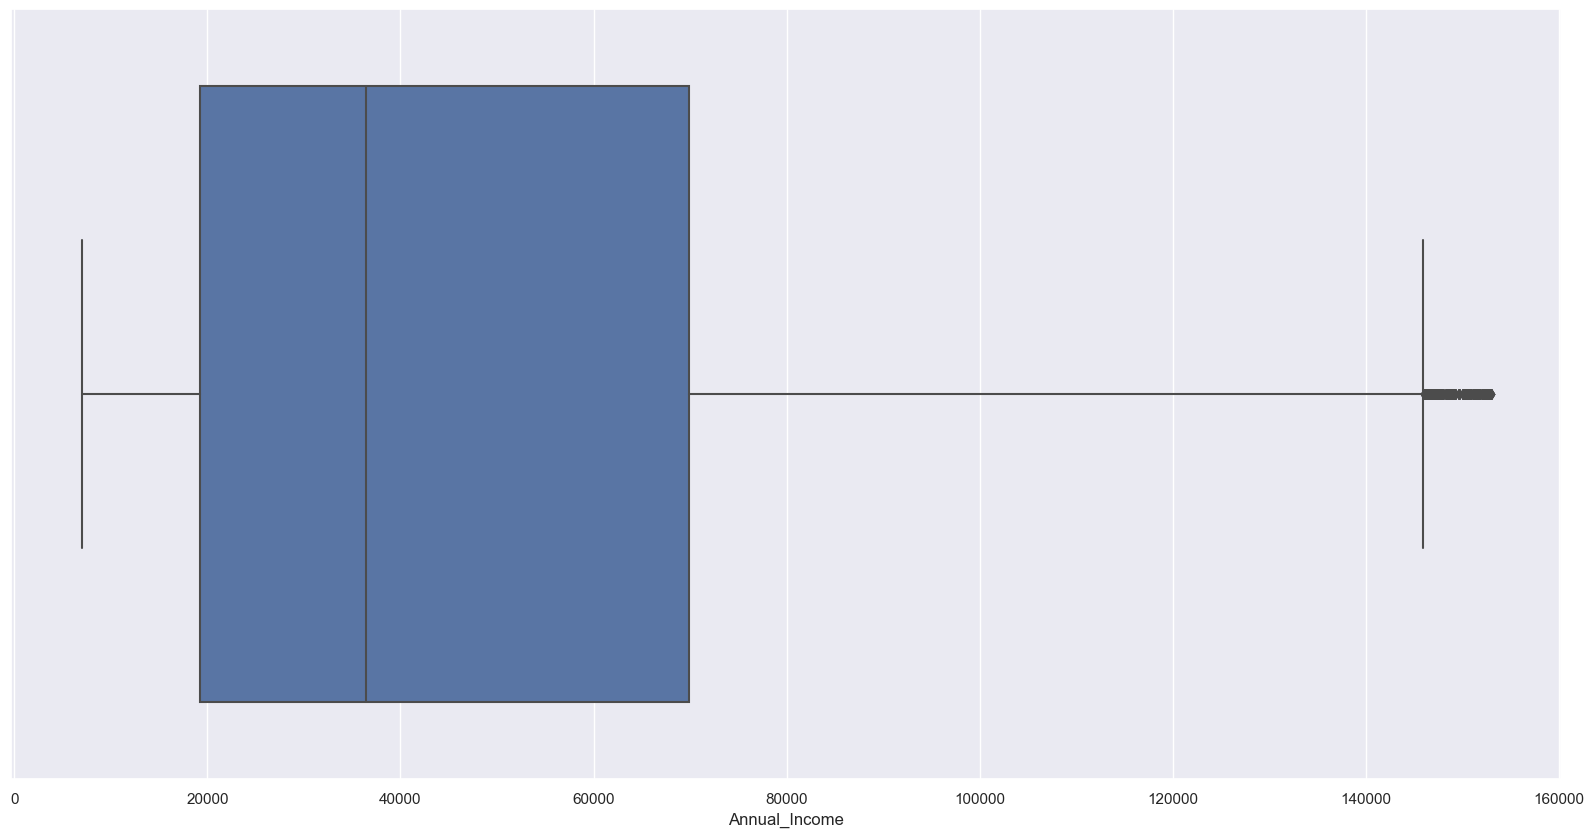

In [2594]:
sns.boxplot(x=final_dataset['Annual_Income'])

<AxesSubplot:xlabel='Credit_History_Age'>

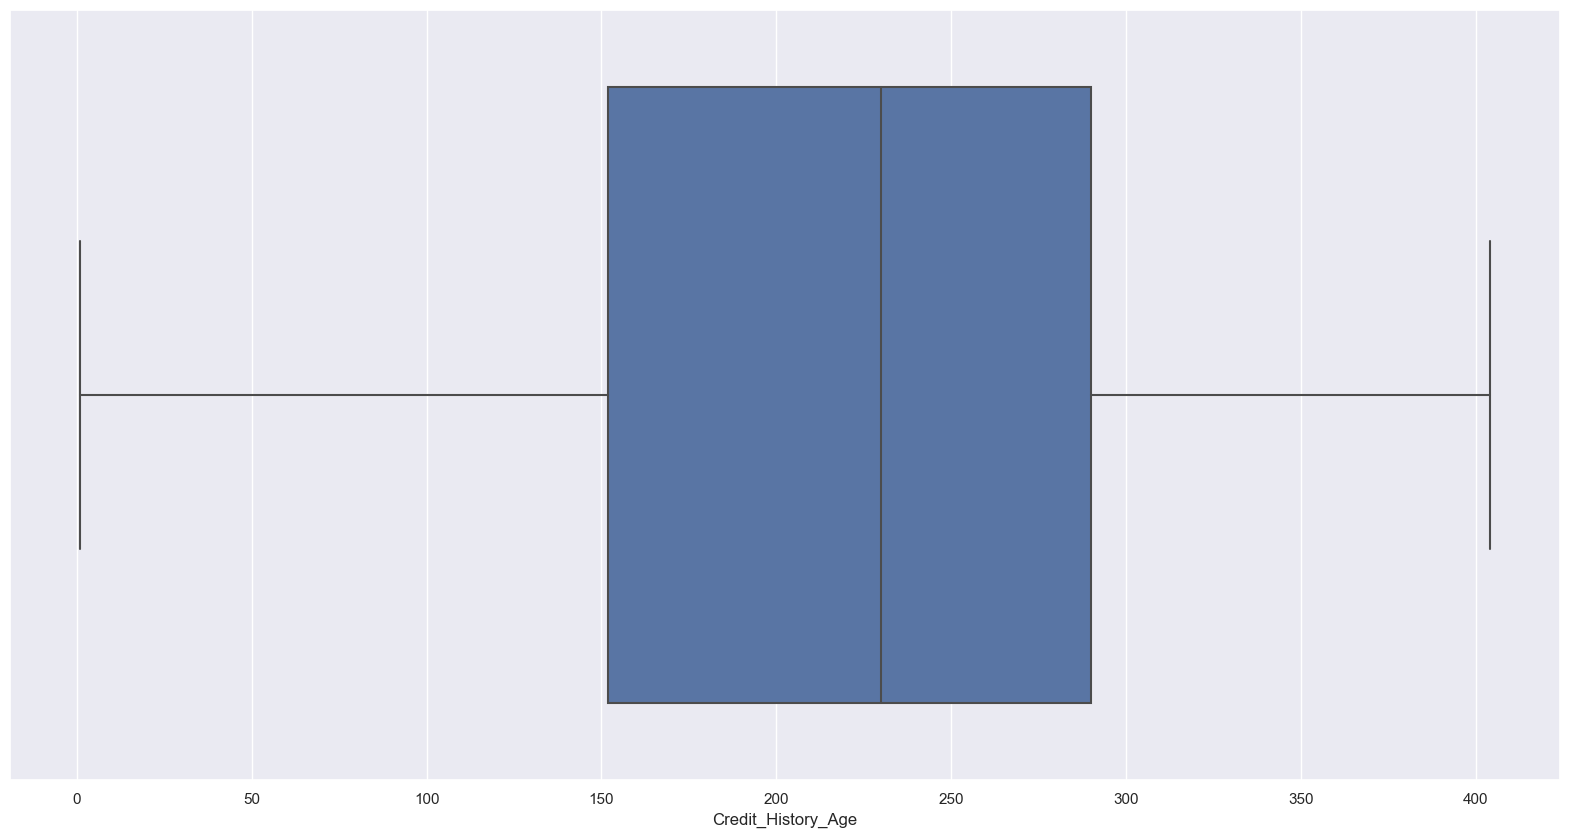

In [2595]:
sns.boxplot(x=final_dataset['Credit_History_Age'])

<AxesSubplot:xlabel='Outstanding_Debt'>

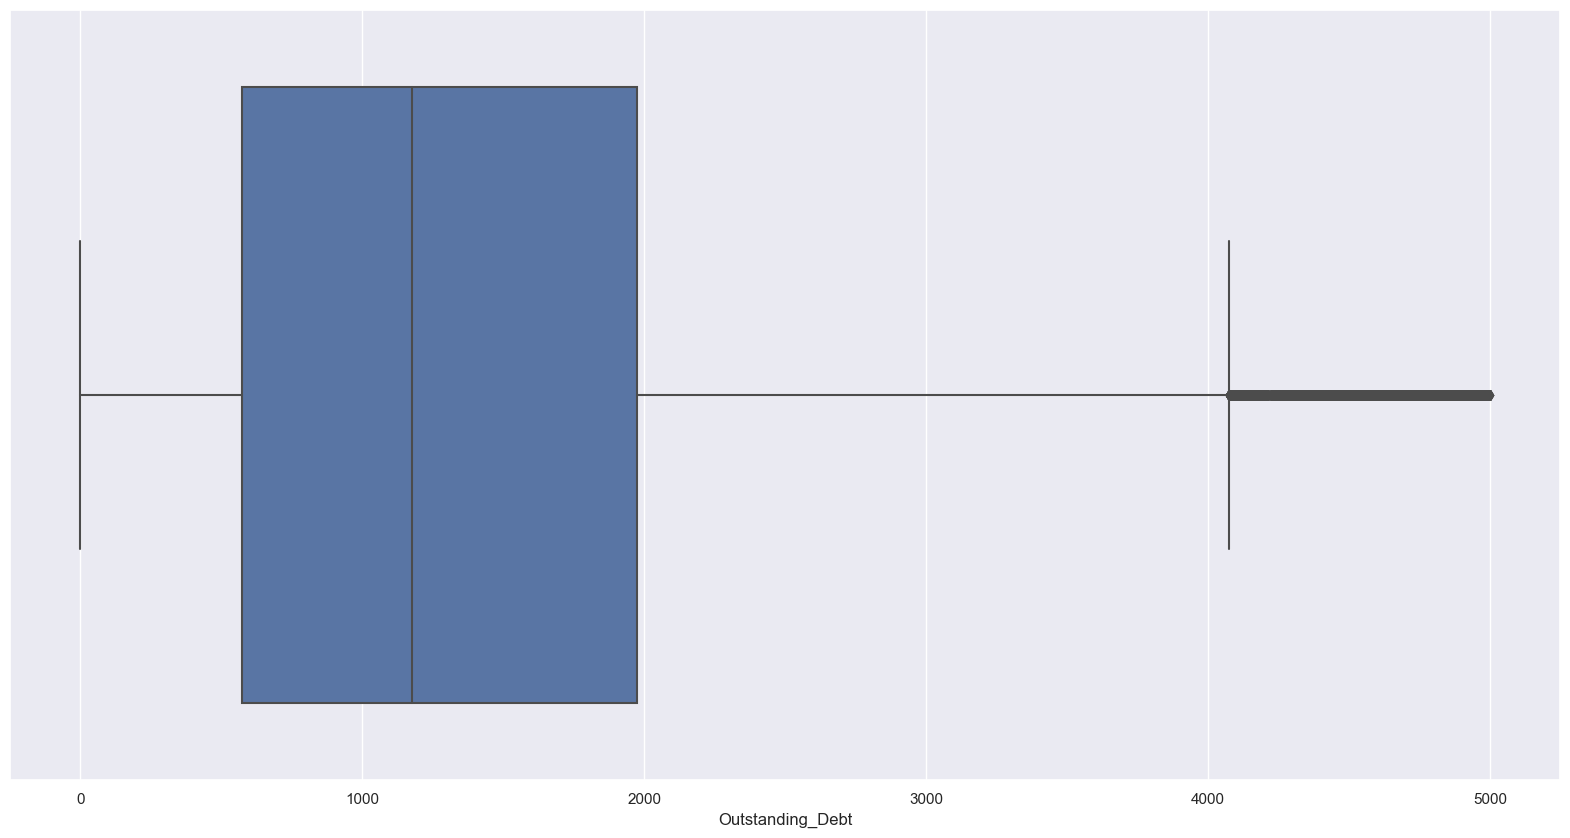

In [2596]:
sns.boxplot(x=final_dataset['Outstanding_Debt'])

In [2597]:
#Occupation count
counting_occupation = final_dataset['Occupation'].value_counts(dropna=False)
counting_occupation

Lawyer           5897
Architect        5712
Engineer         5707
Mechanic         5663
Scientist        5642
Teacher          5610
Accountant       5595
Media_Manager    5587
Entrepreneur     5584
Developer        5576
Journalist       5477
Doctor           5461
Manager          5361
Musician         5327
Writer           5302
Name: Occupation, dtype: int64

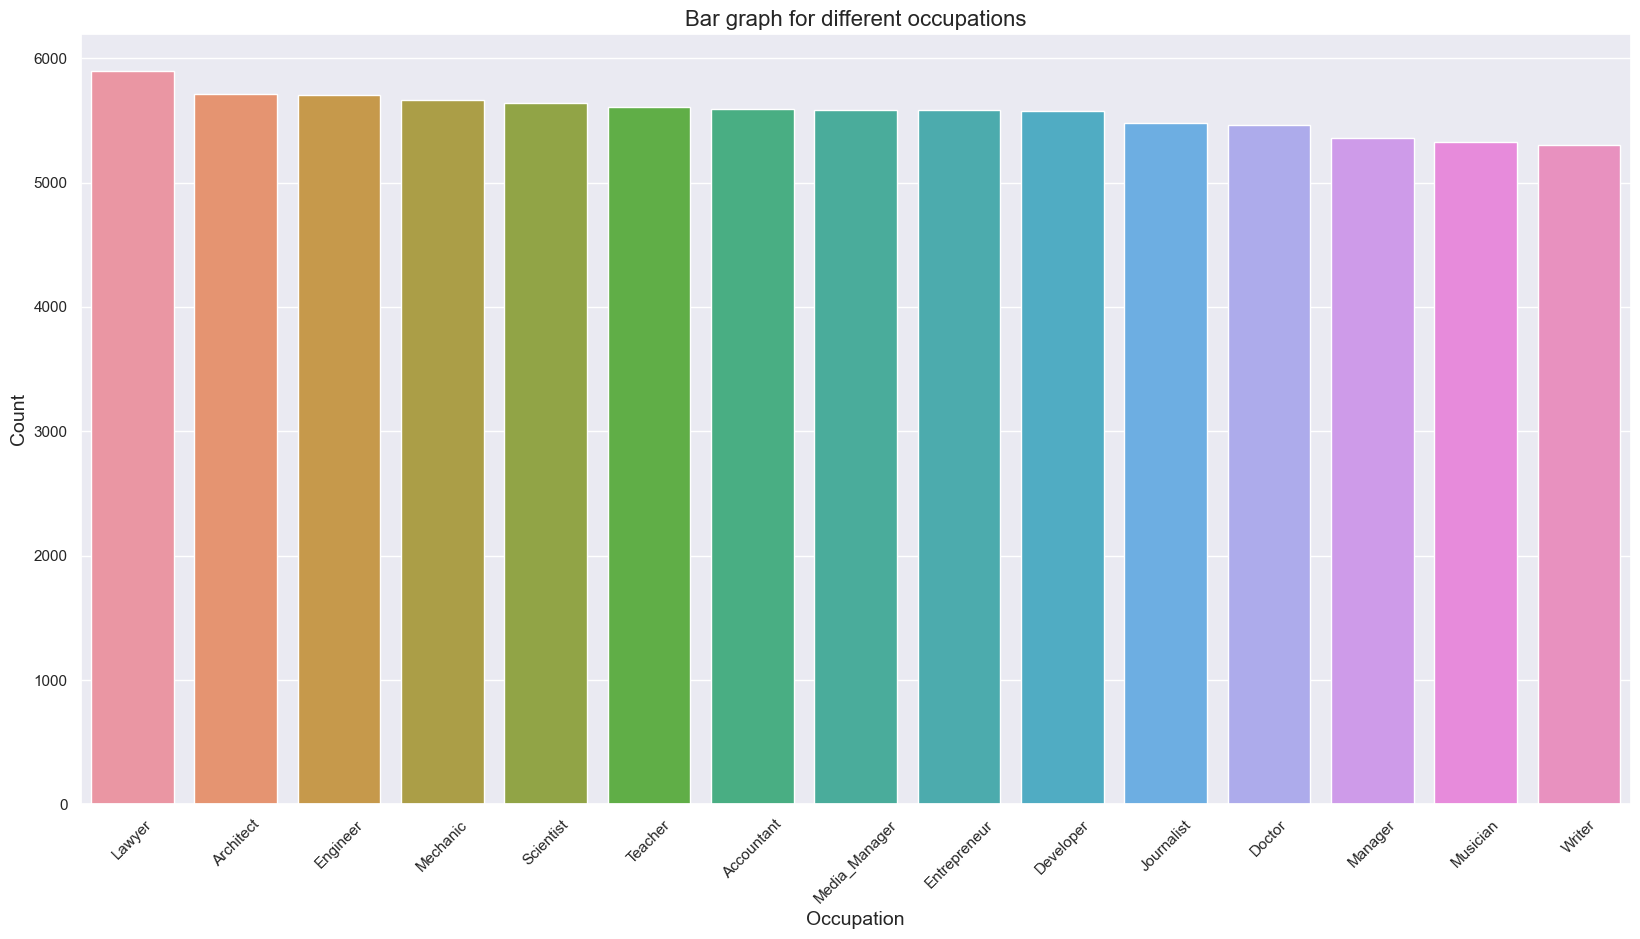

In [2598]:
#Bar graph for occupations
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x=counting_occupation.index, y=counting_occupation.values)
plt.title('Bar graph for different occupations', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Occupation', fontsize=14)
plt.xticks(rotation=45)
plt.show()

Lets work on the outliers in different columns like "Num_of_Delayed_Payment", "Total_EMI_per_month", "Num_of_Loan" and "Annual_Income"

In [2599]:
#sorted(final_dataset['Num_of_Delayed_Payment'])

In [2600]:
#quantile1, quantile3 = np.percentile(final_dataset['Num_of_Delayed_Payment'],[25,75])

In [2601]:
#print(quantile1,quantile3)

In [2602]:
#iqr_value = quantile3 - quantile1
#print(iqr_value)

#lowerbound = quantile1 - (1.5 * iqr_value)
#upperbound = quantile3 + (1.5 * iqr_value)
#print(lowerbound,upperbound)

# Credit score card modelling using Weight of Evidence and information value

In [2603]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83501 entries, 0 to 85851
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   ID                        83501 non-null  object  
 1   Customer_ID               83501 non-null  category
 2   Month                     83501 non-null  object  
 3   Name                      75159 non-null  object  
 4   Age                       83501 non-null  object  
 5   SSN                       83501 non-null  object  
 6   Occupation                83501 non-null  object  
 7   Annual_Income             83501 non-null  float64 
 8   Monthly_Inhand_Salary     83501 non-null  float64 
 9   Num_Bank_Accounts         83501 non-null  int64   
 10  Num_Credit_Card           83501 non-null  int64   
 11  Interest_Rate             83501 non-null  int64   
 12  Num_of_Loan               83501 non-null  float64 
 13  Type_of_Loan              74146 non-null  obje

In [2604]:
#Removing features 
sc_dataset = final_dataset.drop(columns=['ID', 'Customer_ID','Month','Name', 'Monthly_Inhand_Salary','Interest_Rate','Num_of_Loan','Num_Bank_Accounts','SSN','Changed_Credit_Limit', 'Credit_Mix', 'Num_Credit_Inquiries', 'Credit_Utilization_Ratio', 'Amount_invested_monthly','Type_of_Loan'], axis=1)

In [2605]:
sc_dataset['Payment_of_Min_Amount'].head(20)

0     2
1     2
2     2
3     2
4     2
5     2
6     2
7     2
8     2
9     2
10    2
11    2
12    0
13    2
14    2
15    2
16    2
17    2
18    2
19    2
Name: Payment_of_Min_Amount, dtype: int64

In [2606]:
# Revise the incorrect data
sym = '\\`*_{}[]()>#@+!$:;'
col_int = ['Age','Annual_Income','Delay_from_due_date','Num_of_Delayed_Payment',
           'Outstanding_Debt','Total_EMI_per_month', 'Monthly_Balance']

col_str = ['Occupation', 'Credit_History_Age','Payment_of_Min_Amount','Credit_Score']

for i in col_int:
    for c in sym:
        sc_dataset[i] = sc_dataset[i].astype(str).str.replace(c,'')
        
for i in col_str:
    for c in sym:
        sc_dataset[i] = sc_dataset[i].astype(str).str.replace(c,'')

sc_dataset.head()

/var/folders/nf/g_4jhvds3hl6w0x8k1y827z80000gn/T/ipykernel_12768/88797409.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sc_dataset[i] = sc_dataset[i].astype(str).str.replace(c,'')
/var/folders/nf/g_4jhvds3hl6w0x8k1y827z80000gn/T/ipykernel_12768/88797409.py:14: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sc_dataset[i] = sc_dataset[i].astype(str).str.replace(c,'')


,Age,Occupation,Annual_Income,Num_Credit_Card,Delay_from_due_date,Num_of_Delayed_Payment,Outstanding_Debt,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Payment_Behaviour,Monthly_Balance,Credit_Score
0,23,Scientist,19114.12,4,3.0,7.0,809.98,265.0,2,49.57494921489417,4.0,312.49408867943663,Good
1,23,Scientist,19114.12,4,-1.0,6.5,809.98,267.5,2,49.57494921489417,3.0,284.62916249607184,Good
2,-500,Scientist,19114.12,4,3.0,7.0,809.98,267.0,2,49.57494921489417,2.0,331.2098628537912,Good
3,23,Scientist,19114.12,4,5.0,4.0,809.98,268.0,2,49.57494921489417,1.0,223.45130972736786,Good
4,23,Scientist,19114.12,4,6.0,6.5,809.98,269.0,2,49.57494921489417,5.0,341.48923103222177,Good


In [2607]:
#Explore the sc_dataset
sc_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83501 entries, 0 to 85851
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     83501 non-null  object 
 1   Occupation              83501 non-null  object 
 2   Annual_Income           83501 non-null  object 
 3   Num_Credit_Card         83501 non-null  int64  
 4   Delay_from_due_date     83501 non-null  object 
 5   Num_of_Delayed_Payment  83501 non-null  object 
 6   Outstanding_Debt        83501 non-null  object 
 7   Credit_History_Age      83501 non-null  object 
 8   Payment_of_Min_Amount   83501 non-null  object 
 9   Total_EMI_per_month     83501 non-null  object 
 10  Payment_Behaviour       83501 non-null  float64
 11  Monthly_Balance         83501 non-null  object 
 12  Credit_Score            83501 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 8.9+ MB


In [2638]:
sc_dataset['Num_of_Delayed_Payment'] = sc_dataset['Num_of_Delayed_Payment'].astype(str).str.replace('-','0')

In [2639]:
col_int2 = ['Age', 'Delay_from_due_date','Num_of_Delayed_Payment','Outstanding_Debt',
           'Total_EMI_per_month','Monthly_Balance','Payment_Behaviour','Credit_History_Age','Annual_Income']

for i in col_int2:
    sc_dataset[i] = sc_dataset[i].astype(float)
sc_dataset.dtypes

Age                       float64
Occupation                 object
Annual_Income             float64
Num_Credit_Card             int64
Delay_from_due_date       float64
Num_of_Delayed_Payment    float64
Outstanding_Debt          float64
Credit_History_Age        float64
Payment_of_Min_Amount      object
Total_EMI_per_month       float64
Payment_Behaviour         float64
Monthly_Balance           float64
Credit_Score               object
Delay_from_due_datet      float64
good_bad                    int64
dtype: object

In [2640]:
#Adjusting negative values to 0
neg_col = ['Delay_from_due_date','Num_of_Delayed_Payment']



for i in neg_col:
    sc_dataset.loc[sc_dataset[i] < 0, i] *= 0 * sc_dataset[i]
    

In [2641]:
sc_dataset['Occupation'].head(10)

0    Scientist
1    Scientist
2    Scientist
3    Scientist
4    Scientist
5    Scientist
6    Scientist
7      Teacher
8      Teacher
9      Teacher
Name: Occupation, dtype: object

In [2643]:
#Using the Inter Quantile Range to drop outliers in age

sc_dataset['Age'] = pd.to_numeric(sc_dataset['Age'])
median_age = sc_dataset['Age'].median()
sc_dataset.loc[sc_dataset['Age'] < 18, 'Age'] = median_age 
sc_dataset.loc[sc_dataset['Delay_from_due_date'] < 1, 'Delay_from_due_date'] = 0 

In [2652]:
#create a new column based on delayed payments to be our target variable
sc_dataset['good_bad'] = np.where(sc_dataset['Payment_Behaviour'] < 2, 0,1)


#We would drop the original value of delayed payments
sc_dataset  = sc_dataset.drop(columns = ['Payment_Behaviour','Credit_Score','Delay_from_due_datet'],axis=1)


In [2655]:
# Split data into testing and training data by 20:80 keeping the distribution of bad loans in the test as that in the pre-split dataset
X = sc_dataset.drop(columns=['good_bad'], axis=1)
y = sc_dataset['good_bad'] 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

#Hard copying to avoid errors from Pandas
X_train, X_test = X_train.copy(), X_test.copy()

In [2656]:
X_train.isna().sum()

Age                       0
Occupation                0
Annual_Income             0
Num_Credit_Card           0
Delay_from_due_date       0
Num_of_Delayed_Payment    0
Outstanding_Debt          0
Credit_History_Age        0
Payment_of_Min_Amount     0
Total_EMI_per_month       0
Monthly_Balance           0
dtype: int64

### Feature selection

In [2669]:
#DIviding variables into categorical and numerical features

X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'float').copy()

In [2670]:
#Empty dictionary to store chi-squared test results
chiSq_check = {}

#loop over column in the training set to calculate chi-statistics with the largest variable
for column in X_train_cat:
    chi, p, dot, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chiSq_check.setdefault('Feature',[]).append(column)
    chiSq_check.setdefault('p-value',[]).append(round(p, 10))
    
#convert the dictionary to a DF
chiSq_result = pd.DataFrame(data = chiSq_check)
chiSq_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chiSq_result


,Feature,p-value
0,Payment_of_Min_Amount,0.000000
1,Occupation,0.568384


### ANOVA F-Statistic for numerical features

In [2672]:
# Calculate F Statistic and corresponding p values

imputer = SimpleImputer(strategy='mean')
X_train_num_imputed = imputer.fit_transform(X_train_num)

F_statistic, p_values = f_classif(X_train_num_imputed, y_train)

#convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,Annual_Income,5661.451993,0.000000
1,Outstanding_Debt,569.094496,0.000000
2,Delay_from_due_date,428.193541,0.000000
3,Credit_History_Age,388.091327,0.000000
4,Age,6.264682,0.012319
5,Num_of_Delayed_Payment,0.805751,0.369383
6,Total_EMI_per_month,0.770916,0.379937
7,Monthly_Balance,0.017583,0.894510


<AxesSubplot:>

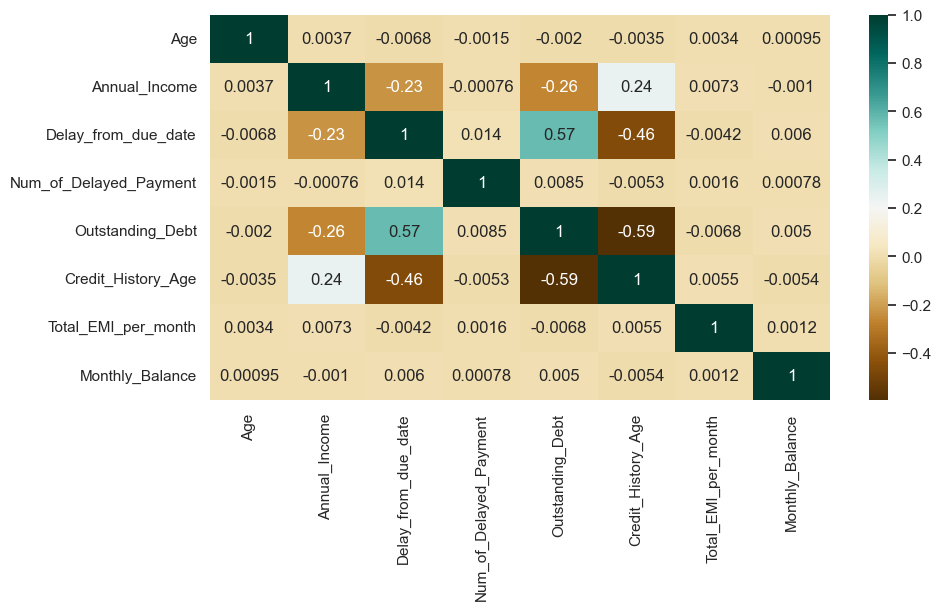

In [2673]:
plt.figure(figsize=(10,5))

c = X_train_num.corr()
sns.heatmap(c, cmap='BrBG', annot=True)

In [2674]:
# function to create dummy variables
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

# apply to categorical variables
X_train = dummy_creation(X_train, ['Occupation', 'Payment_of_Min_Amount'])

In [2675]:
# apply to our final four categorical variables
X_test = dummy_creation(X_test, ['Occupation', 'Payment_of_Min_Amount'])
X_test= X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

In [2533]:
# Cleaning dataset for WoE and IV by type conversion and creating Dummy variables
#sc_dataset['Payment_of_Min_Amount'] = sc_dataset[['Payment_of_Min_Amount']].apply(pd.to_numeric)
#df_dummies = pd.get_dummies(sc_dataset, prefix='Occupation', columns=['Occupation'], drop_first=False)

#x_train = pd.concat([sc_dataset, df_dummies], axis=1)
#X_train.head(30)
#X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

### WoE Binning and/Feature Engineering

In [2676]:
# Create copies of the 4 training sets to be prepocessed using WoE
X_train_prepr = X_train.copy()
y_train_prepr = y_train.copy()
X_test_prepr = X_test.copy()
y_test_prepr = y_test.copy()

Analyze WoEs and IVs of discrete features

In [2677]:
# The function takes 3 arguments: a dataframe (X_train_prepr), a string (column name), and a dataframe (y_train_prepr).
# The function returns a dataframe as a result.

def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [2678]:
# We set the default style of the graphs to the seaborn style. 
sns.set()
# Below we define a function for plotting WoE across categories that takes 2 arguments: a dataframe and a number.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

In [2679]:
df_occupation = woe_discrete(X_train_prepr,'Occupation', y_train_prepr)
df_occupation

,Occupation,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Mechanic,4529,0.707441,0.067799,3204.0,1325.0,0.066595,0.070901,-0.062662,NaN,NaN,0.000925
1,Journalist,4332,0.709834,0.064850,3075.0,1257.0,0.063913,0.067262,-0.051073,0.002393,0.011589,0.000925
2,Teacher,4573,0.716160,0.068458,3275.0,1298.0,0.068070,0.069456,-0.020157,0.006326,0.030916,0.000925
3,Engineer,4563,0.716853,0.068308,3271.0,1292.0,0.067987,0.069135,-0.016746,0.000693,0.003411,0.000925
4,MediaManager,4472,0.717800,0.066946,3210.0,1262.0,0.066719,0.067530,-0.012077,0.000947,0.004669,0.000925
5,Accountant,4494,0.718069,0.067275,3227.0,1267.0,0.067073,0.067798,-0.010749,0.000269,0.001328,0.000925
6,Developer,4506,0.718375,0.067455,3237.0,1269.0,0.067281,0.067905,-0.009232,0.000307,0.001517,0.000925
7,Doctor,4350,0.720230,0.065120,3133.0,1217.0,0.065119,0.065122,-0.000048,0.001854,0.009184,0.000925
8,Manager,4269,0.723120,0.063907,3087.0,1182.0,0.064163,0.063249,0.014342,0.002890,0.014390,0.000925
9,Musician,4272,0.723315,0.063952,3090.0,1182.0,0.064225,0.063249,0.015313,0.000194,0.000971,0.000925


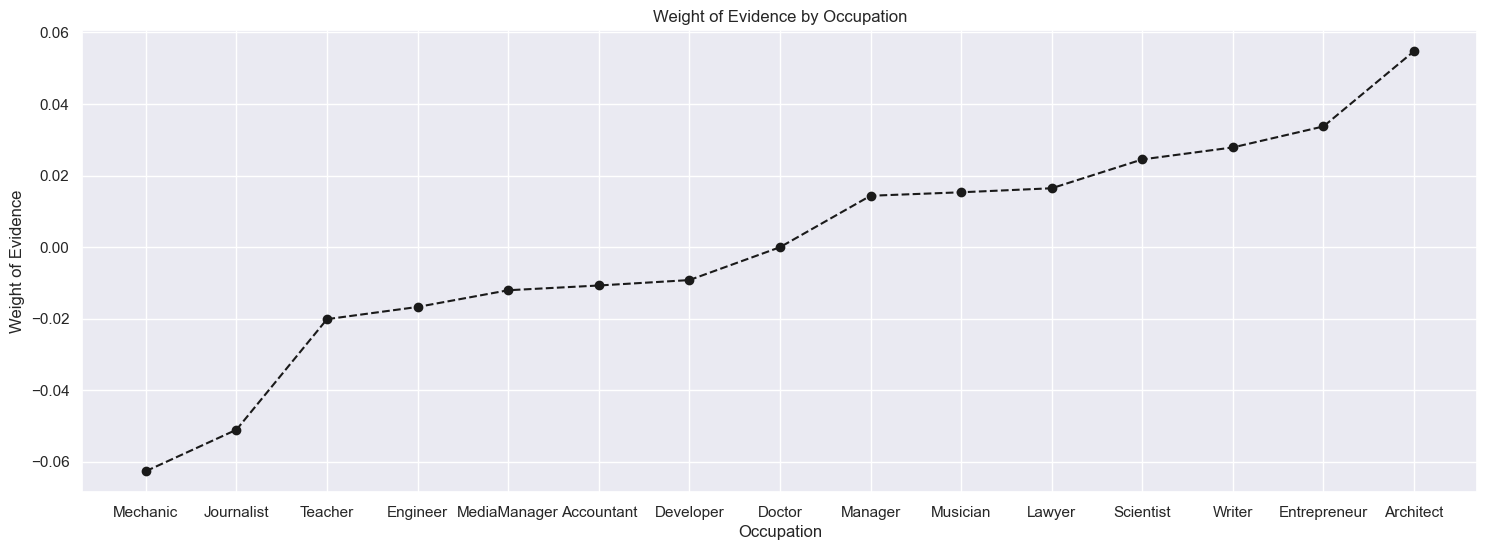

In [2680]:
plot_by_woe(df_occupation)

There's a continues increase in WoE across the different grades. Therefore, we do not need to combine any features together and should leave all these 7 grades as they are

In [2681]:
#
df_temp = woe_discrete(X_train_prepr,'Payment_of_Min_Amount', y_train_prepr)
df_temp

,Payment_of_Min_Amount,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,1,35543,0.690431,0.532081,24540.0,11003.0,0.51006,0.588774,-0.143514,NaN,NaN,0.029214
1,0,8030,0.723537,0.120210,5810.0,2220.0,0.12076,0.118793,0.016423,0.033105,0.159937,0.029214
2,2,23227,0.764713,0.347710,17762.0,5465.0,0.36918,0.292434,0.233047,0.041177,0.216624,0.029214


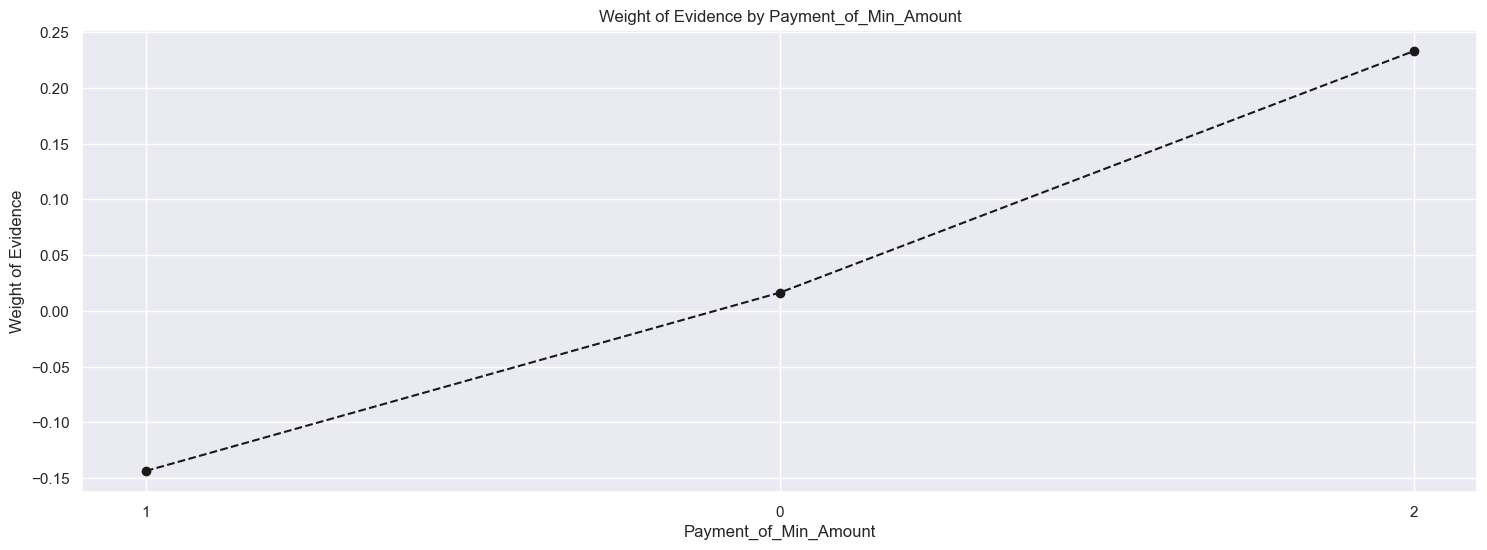

In [2682]:
plot_by_woe(df_Payment_of_Min_Amount)

Analyze WoEs and IVs of numeric fetures

In [2683]:
# We define a function to calculate WoE of continuous variables. This is same as the function we defined earlier for discrete variables.
# The only difference are the 2 commented lines of code in the function that results in the df being sorted by continuous variable values
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log((df['prop_n_good'] + 1e-6) / (df['prop_n_bad'] + 1e-6))
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [2542]:
#plot_by_woe(df_Annual_Income)

In [2684]:
#fine-classing 
X_train_prepr['Annual_Income'] = pd.cut(X_train_prepr['Annual_Income'], 50)
df_temp = woe_ordered_continuous(X_train_prepr, 'Annual_Income', y_train_prepr)
df_temp

,Annual_Income,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(6859.989, 9924.754]",3764,0.496546,0.056347,1869.0,1895.0,0.038847,0.101402,-0.959449,NaN,NaN,0.557761
1,"(9924.754, 12843.578]",2010,0.491045,0.030090,987.0,1023.0,0.020515,0.054741,-0.981444,0.005501,0.021995,0.557761
2,"(12843.578, 15762.401]",4080,0.479657,0.061078,1957.0,2123.0,0.040676,0.113602,-1.027052,0.011388,0.045607,0.557761
3,"(15762.401, 18681.225]",5921,0.529302,0.088638,3134.0,2787.0,0.065140,0.149133,-0.828297,0.049646,0.198755,0.557761
4,"(18681.225, 21600.049]",5205,0.609606,0.077919,3173.0,2032.0,0.065950,0.108733,-0.499987,0.080304,0.328310,0.557761
5,"(21600.049, 24518.873]",1639,0.708969,0.024536,1162.0,477.0,0.024152,0.025524,-0.055266,0.099363,0.444721,0.557761
6,"(24518.873, 27437.697]",1292,0.699690,0.019341,904.0,388.0,0.018789,0.020762,-0.099821,0.009278,0.044555,0.557761
7,"(27437.697, 30356.52]",2594,0.696993,0.038832,1808.0,786.0,0.037579,0.042059,-0.112627,0.002697,0.012806,0.557761
8,"(30356.52, 33275.344]",3426,0.711033,0.051287,2436.0,990.0,0.050632,0.052975,-0.045241,0.014040,0.067386,0.557761
9,"(33275.344, 36194.168]",3350,0.722388,0.050150,2420.0,930.0,0.050299,0.049765,0.010688,0.011355,0.055929,0.557761


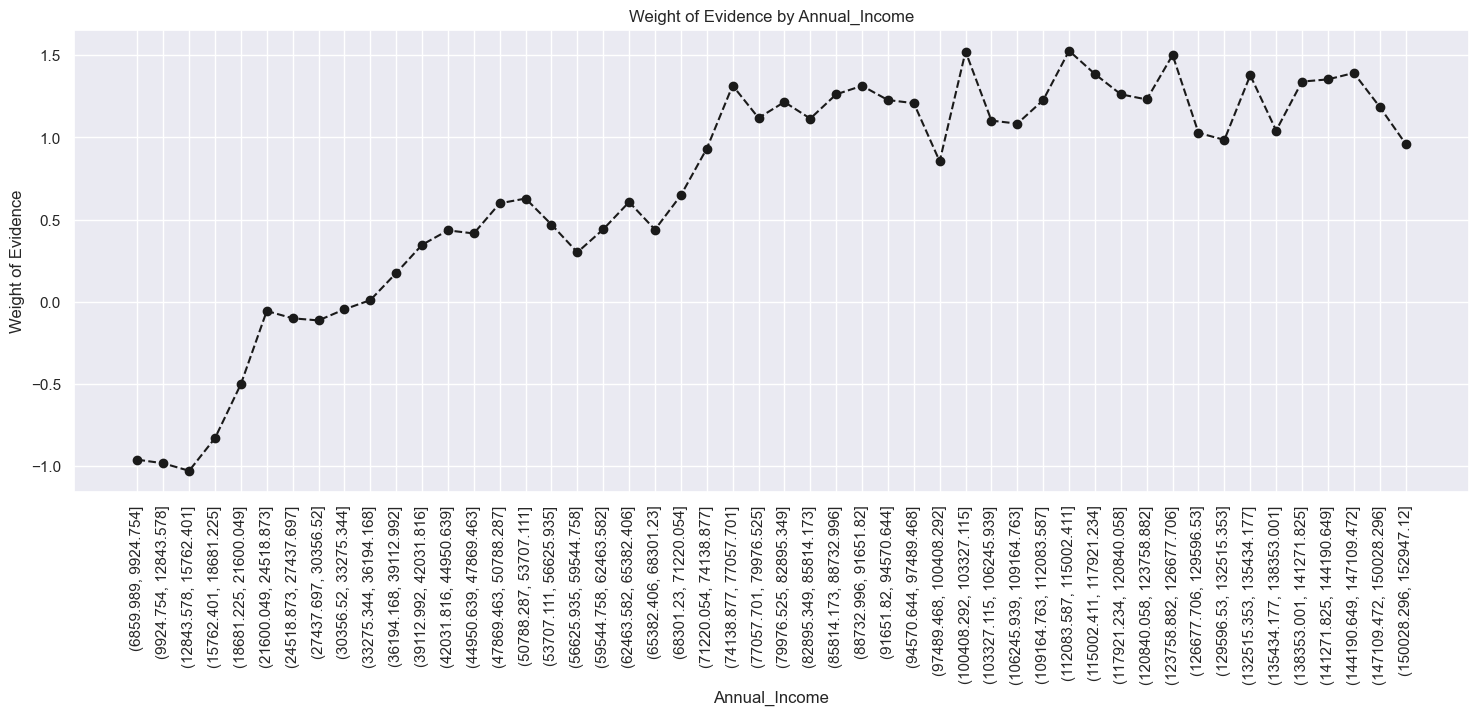

In [2685]:
plot_by_woe(df_temp, 90)

In [2686]:
#Delay from due dates
#X_train_prepr_temp = X_train_prepr[X_train_prepr['Delay_from_due_date'] >= 4].copy()
X_train_prepr['Delay_from_due_date'] = pd.cut(X_train_prepr['Delay_from_due_date'], 30)
df_temp = woe_ordered_continuous(X_train_prepr, 'Delay_from_due_date', y_train_prepr)
df_temp

,Delay_from_due_date,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.067, 2.233]",2865,0.782199,0.042889,2241.0,624.0,0.046579,0.033390,0.332869,NaN,NaN,0.035956
1,"(2.233, 4.467]",2247,0.779261,0.033638,1751.0,496.0,0.036394,0.026541,0.315706,0.002938,0.017162,0.035956
2,"(4.467, 6.7]",4049,0.750803,0.060614,3040.0,1009.0,0.063186,0.053992,0.157245,0.028459,0.158461,0.035956
3,"(6.7, 8.933]",4299,0.758083,0.064356,3259.0,1040.0,0.067738,0.055651,0.196546,0.007281,0.039301,0.035956
4,"(8.933, 11.167]",6407,0.752458,0.095913,4821.0,1586.0,0.100204,0.084867,0.166114,0.005625,0.030432,0.035956
5,"(11.167, 13.4]",4306,0.754064,0.064461,3247.0,1059.0,0.067488,0.056667,0.174754,0.001606,0.008639,0.035956
6,"(13.4, 15.633]",4618,0.736249,0.069132,3400.0,1218.0,0.070668,0.065176,0.080914,0.017815,0.093840,0.035956
7,"(15.633, 17.867]",3430,0.719242,0.051347,2467.0,963.0,0.051276,0.051530,-0.004945,0.017007,0.085859,0.035956
8,"(17.867, 20.1]",5232,0.717125,0.078323,3752.0,1480.0,0.077985,0.079195,-0.015403,0.002117,0.010458,0.035956
9,"(20.1, 22.333]",3212,0.710772,0.048084,2283.0,929.0,0.047452,0.049711,-0.046512,0.006353,0.031109,0.035956


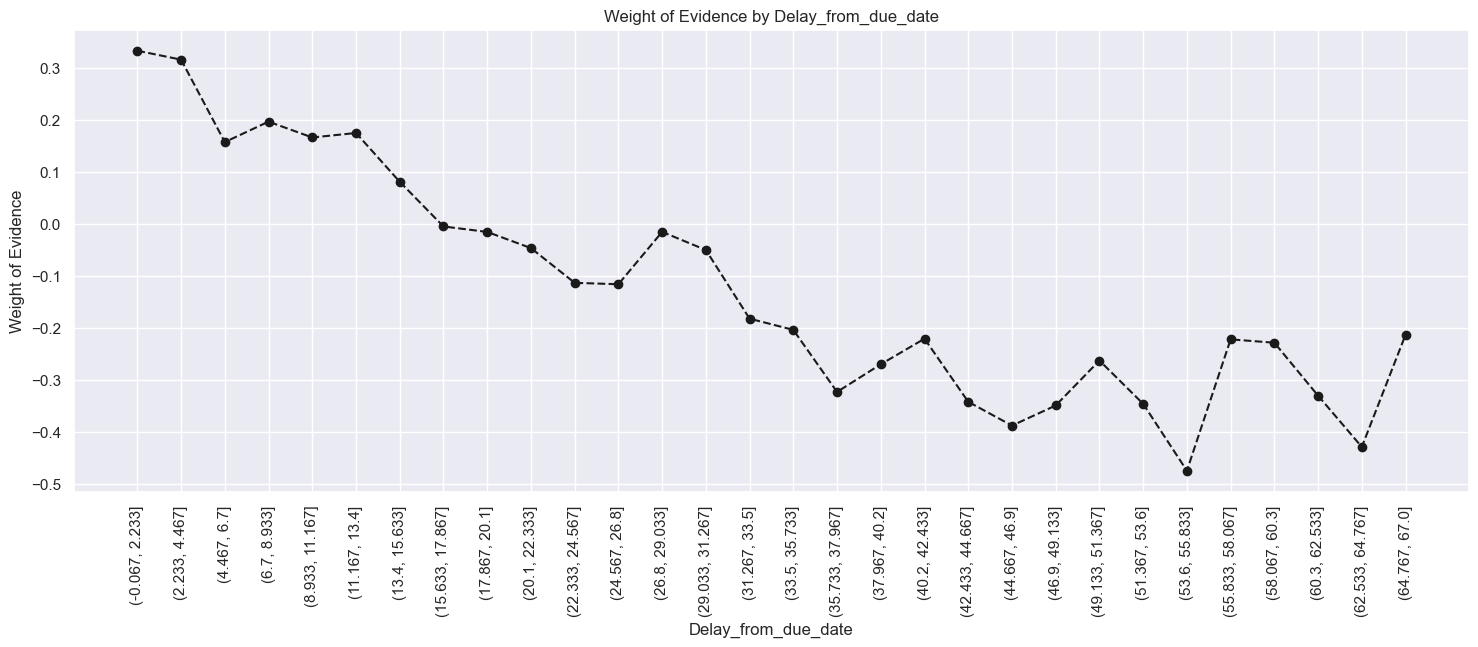

In [2688]:
plot_by_woe(df_temp, 90)